<a href="https://colab.research.google.com/github/hosngholami/RecommenderSystem/blob/main/RecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install opendatasets
!pip install geopy
!pip install folium
!pip install -U pymoo
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.9 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=25c91ba88c2ec127abbfd3ed23a114c0d547bbfa3ab4f3bee316871e32b9bfe8
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [4]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", 1000)
pd.set_option('display.max_rows', 1000)
np.set_printoptions(threshold=np.inf)

In [5]:
import random
import matplotlib.pyplot as plt
locations = pd.read_csv('/content/drive/MyDrive/Shiraz/locations.csv')
locations["Id"] = [i for i in range(0, len(locations))]
locations["Stars"] = 0
locations["Price"] = 0
# locations["Price"] = [random.randint(10, 200) for i in range(len(locations))]

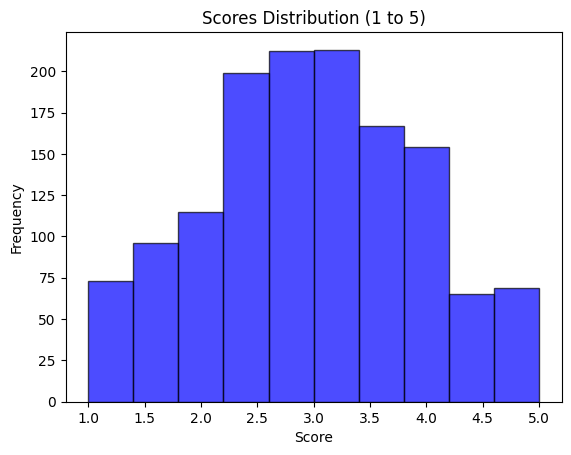

In [6]:
mean_score = 3  # میانگین امتیاز (در وسط بازه 1 تا 5)
std_dev = 1     # انحراف معیار امتیاز

# تعداد آیتم‌ها
num_items = len(locations)

# تولید امتیازات خام با توزیع نرمال
raw_scores = np.random.normal(mean_score, std_dev, num_items)
scores = np.clip(raw_scores, 1, 5)
data = pd.DataFrame({'Item': [f'Item_{i+1}' for i in range(num_items)], 'Score': scores})

# مرتب‌سازی بر اساس امتیاز و اختصاص رتبه
data = data.sort_values(by='Score', ascending=False).reset_index(drop=True)
data['Rank'] = data.index + 1

# رسم هیستوگرام امتیازات
plt.hist(scores, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Scores Distribution (1 to 5)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

locations["Stars"] = scores

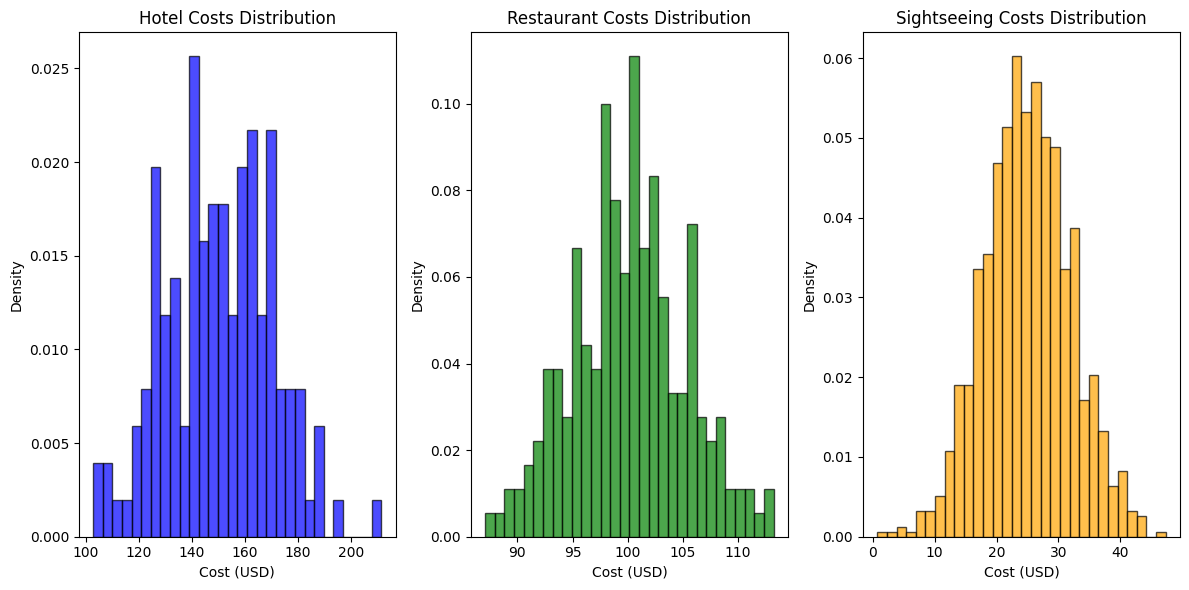

In [7]:
import numpy as np


# تعداد مکان‌ها
num_hotels = len(locations[locations["type"] == "hotel"])         # تعداد هتل‌ها
num_restaurants = len(locations[locations["type"] == "restaurant"])    # تعداد رستوران‌ها
num_sightseeing = len(locations[~locations["type"].isin(['hotel', 'restaurant'])])    # تعداد مکان‌های دیدنی

# پارامترهای توزیع نرمال برای هزینه‌های واحد
# هزینه هتل
mean_hotel = 150  # میانگین هزینه هر هتل (دلار)
std_hotel = 20    # انحراف معیار هزینه هر هتل

# هزینه رستوران
mean_restaurant = 100  # میانگین هزینه هر رستوران (دلار)
std_restaurant = 5    # انحراف معیار هزینه هر رستوران

# هزینه مکان‌های دیدنی
mean_sightseeing = 25  # میانگین هزینه هر مکان دیدنی (دلار)
std_sightseeing = 7     # انحراف معیار هزینه هر مکان دیدنی

# تولید هزینه‌ها برای هر بخش
hotel_costs = np.random.normal(mean_hotel, std_hotel, num_hotels)
restaurant_costs = np.random.normal(mean_restaurant, std_restaurant, num_restaurants)
sightseeing_costs = np.random.normal(mean_sightseeing, std_sightseeing, num_sightseeing)

# رسم نمودار توزیع نرمال برای هر بخش
plt.figure(figsize=(12, 6))

# نمودار هتل‌ها
plt.subplot(1, 3, 1)
plt.hist(hotel_costs, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title('Hotel Costs Distribution')
plt.xlabel('Cost (USD)')
plt.ylabel('Density')

# نمودار رستوران‌ها
plt.subplot(1, 3, 2)
plt.hist(restaurant_costs, bins=30, color='green', alpha=0.7, edgecolor='black', density=True)
plt.title('Restaurant Costs Distribution')
plt.xlabel('Cost (USD)')
plt.ylabel('Density')

# نمودار مکان‌های دیدنی
plt.subplot(1, 3, 3)
plt.hist(sightseeing_costs, bins=30, color='orange', alpha=0.7, edgecolor='black', density=True)
plt.title('Sightseeing Costs Distribution')
plt.xlabel('Cost (USD)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()



indexHotel = locations[locations["type"] == "hotel"].index

for i in indexHotel:
   locations.loc[i, "Price"] = int(hotel_costs[i])

indexRestaurant = locations[locations["type"] == "restaurant"].index

c = 0
for i in indexRestaurant:
   locations.loc[i, "Price"] = restaurant_costs[c]
   c += 1


c = 0
indexSightseeing = locations[~locations["type"].isin(['hotel', 'restaurant'])].index
for i in indexSightseeing:
   locations.loc[i, "Price"] = sightseeing_costs[c]
   c +=1



In [ ]:
set(locations["type"])

{'caffe',
 'historic',
 'hotel',
 'museum',
 'park',
 'placeofworship',
 'restaurant',
 'swimmingpool'}

In [8]:
def getLocation():
   location = locations[locations["type"] != "hotel"].sample(n=1)
   return location["Id"].values[0]

In [9]:
def getLocationById(id):
   location = locations[locations["Id"] == id]
   return location


In [10]:
class GeneticAlgorithmConfig():
  totalLocationSize = 1
  hotelSize = 1
  numberLocationSize = len(locations[locations["type"] != "hotel"])
  totalRouteSize = 30
  timePlaceMappingSize = 2
  n_var = ((numberLocationSize * timePlaceMappingSize) +
         (hotelSize * timePlaceMappingSize) +
         (totalLocationSize))
  maxDistance = -1
  maxCost = -1
  maxRate = -1
  pareto_generations = []
  number_genrations = 0
  preference = {}
  best = []
  cost_variance = []
  distance_variance = []
  rate_variance = []
  distance_diversity = []
  cost_diversity = []
  rate_diversity = []
  GD = []
  HV = []
  firstFront = []
  ref_points = 0
  cd = []
  mpd_decision = []
  mpd_objective = []



In [11]:
def getSliceRoute(route):
  length = route[0] * GeneticAlgorithmConfig.timePlaceMappingSize
  startHead = GeneticAlgorithmConfig.hotelSize
  endHead = (GeneticAlgorithmConfig.hotelSize * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize

  startTail = length + endHead
  endTail  = length + endHead + GeneticAlgorithmConfig.timePlaceMappingSize
  interior = []
  if(route[0] != 0):
      interior = route[endHead:startTail]

  return (route[startHead:endHead], interior, route[startTail:endTail])

In [12]:
userPreference = {"Historical": 0.01,
                  "Recreational": 0.01,
                  "Natural": 0.01,
                  "Adventure": 0.01,
                  "Religious": 0.01,
                  "Resort": 0.01,
                  "Artistic": 0.01,
                  "Photography": 0.01,
                  "Cultural": 5}

In [13]:
locations["tag"] = [[] for _ in range(len(locations))]

In [14]:
preference = userPreference.keys()
prefernce = list(preference)
prefernce = [key for key in preference if key != 'Resort']




index = locations[locations["type"] != "hotel"].index


for i in index:
  countRandom = np.random.randint(0, len(prefernce))
  if(countRandom == 0):
    countRandom = 1
  for _ in range(countRandom):
    rand = np.random.randint(0, len(prefernce))
    if(rand == 0):
      tag = prefernce[2]
      if(tag not in locations.iloc[i]["tag"]):
        locations.iloc[i]["tag"].append(tag)
    else:
      for _ in range(0, rand):
        tag = prefernce[rand]
        if(tag not in locations.iloc[i]["tag"]):
          locations.iloc[i]["tag"].append(tag)

# locations

In [15]:
index = locations[locations["type"] == "hotel"].index
for i in index:
  if('Resort' not in locations.iloc[i]["tag"]):
    locations.iloc[i]["tag"].append('Resort')
locations

,Unnamed: 0,name,name:en,tag,type,Latitude,Longitude,Id,Stars,Price
0,0,هتل هما,Homa Hotel,[Resort],hotel,52.542056,29.627516,0,3.565870,152.000000
1,1,ITTIC,NaN,[Resort],hotel,52.572353,29.611979,1,1.111396,168.000000
2,2,هتل جهانگردی,NaN,[Resort],hotel,52.572018,29.611642,2,2.129216,103.000000
3,3,هتل آریو برزن,Aryo Barzan Hotel,[Resort],hotel,52.541213,29.622286,3,3.229260,145.000000
4,4,هتل کریمخان,Karim Khan Hotel,[Resort],hotel,52.541173,29.622023,4,1.208037,142.000000
...,...,...,...,...,...,...,...,...,...,...
1358,1358,کافه قرار,Gharar Café,[Religious],caffe,52.479574,29.571434,1358,4.069014,23.511169
1359,1359,کافه سه کنج,Seh Konj Cafe,[Religious],caffe,52.537592,29.616573,1359,3.205426,27.575002
1360,1360,کافه پدربزرگ,Pedarbozorg Cafe,[Artistic],caffe,52.506764,29.581426,1360,4.277699,12.998915
1361,1361,کافهtohi,NaN,[Recreational],caffe,52.569189,29.591688,1361,4.403731,30.403586


In [16]:
def meanPairwiseDistance(population):

  distances = 0

  for i in range(len(population)):
    for j in range(len(population)):
      if( i != j):
        a = population[i]
        b = population[j]



        len_a = len(a)
        len_b = len(b)

        maxLength = max(len(a), len(b))

        a = np.pad(a, (0, maxLength - len_a), mode='constant', constant_values=0)
        b = np.pad(b, (0, maxLength - len_b), mode='constant', constant_values=0)

        distances += np.linalg.norm(a - b)

  return distances



n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |      5 |             - |             -


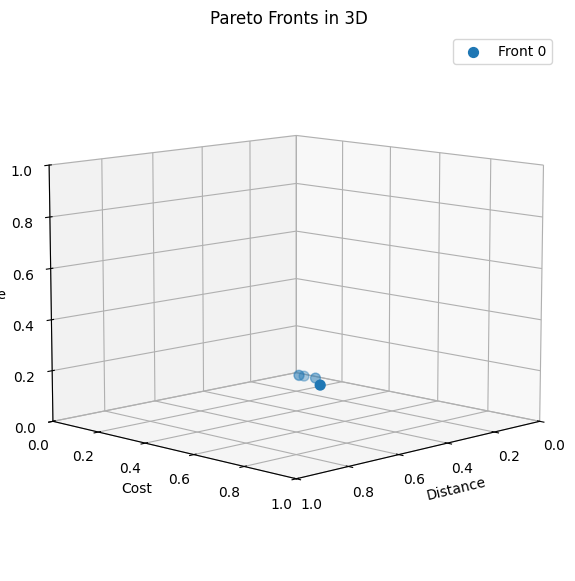

17 95
17 17
33 6
33 33
95 29
95 95
121 52
121 121
52 121
52 52
11 137
11 11
103 67
103 103
84 116
84 84
17 3
17 17
90 54
90 90
90 54
90 90
53 12
53 53
53 12
53 53
12 53
12 12
107 100
107 107
43 5
43 43
134 75
134 134
74 11
74 74
135 0
135 135
135 0
135 135
3 2
3 3
84 92
84 84
61 30
61 61
102 5
102 102
102 5
102 102
100 125
100 100
2 61
2 2
114 3
114 114
3 114
3 3
116 128
116 116
13 30
13 13
11 76
11 11
89 32
89 89
126 66
126 126
128 133
128 128
125 0
125 125
125 0
125 125
106 39
106 106
106 39
106 106
126 70
126 126
86 132
86 86
15 30
15 15
30 15
30 30
119 58
119 119
58 119
58 58
43 114
43 43
52 58
52 52
58 52
58 58
45 111
45 45
111 45
111 111
134 111
134 134
106 74
106 106
35 73
35 35
80 65
80 80
89 2
89 89
49 30
49 49
107 51
107 107
23 121
23 23
27 74
27 27
57 132
57 57
22 98
22 22
114 95
114 114
114 95
114 114
6 26
6 6
134 114
134 134
100 99
100 100
102 53
102 102
44 125
44 44
44 125
44 44
125 44
125 125
114 89
114 114
89 114
89 89
22 40
22 22
50 3
50 50
3 50
3 3
37 119
37 37
90 73


IndexError: index 18 is out of bounds for axis 0 with size 18

In [26]:
import random
import numpy as np
import folium
import matplotlib.pyplot as plt
import math
import ast
import plotly.graph_objects as go

from os import replace
from pymoo.core.crossover import Crossover
from pymoo.core.problem import Problem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population
from pymoo.core.crossover import Crossover
from pymoo.operators.selection.rnd  import RandomSelection
from pymoo.core.sampling import Sampling
from geopy.distance import geodesic
from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
from pymoo.core.callback import Callback
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.core.selection import Selection
from pymoo.visualization.scatter import Scatter
from pymoo.core.mutation import Mutation
from mpl_toolkits import mplot3d
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from mpl_toolkits.mplot3d import Axes3D
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.util.dominator import Dominator
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from pymoo.termination.xtol import DesignSpaceTermination
from pymoo.termination.robust import RobustTermination
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pymoo.util.dominator import Dominator
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.core.survival import Survival
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.operators.survival.rank_and_crowding import RankAndCrowding
from scipy.spatial.distance import pdist
from pymoo.indicators.gd import GD
from pymoo.indicators.hv import HV

def repairSolution(solution, n_var):
   solution = [int(row) for row in solution]

   sample = np.zeros(n_var)




   if(solution[0] != 0):

        length = solution[0] * GeneticAlgorithmConfig.timePlaceMappingSize
        head, interior, tail = getSliceRoute(solution)
        uniqueList = []

        for i in range(0, len(interior),GeneticAlgorithmConfig.timePlaceMappingSize):
          currentLocation = getLocationById(interior[i])
          if(currentLocation["type"].values[0] == "hotel"):
              if(interior[i] != head[0]):
                 print(head[0], interior[i])
                 interior[i] = head[0]
                 print(head[0], interior[i])


          if(interior[i] not in uniqueList):
            for j in range(i, i+GeneticAlgorithmConfig.timePlaceMappingSize, 1):
              uniqueList.append(interior[j])
        lengthSolution = int((len(uniqueList) // GeneticAlgorithmConfig.timePlaceMappingSize))

        uniqueList = [lengthSolution] + head + uniqueList + tail
        return uniqueList

   else:
      return solution


def isValidSolution(solution):
   solution = [int(row) for row in solution]
   startRoute = 1
   endRoute  = (solution[0] * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * 2)
   for i in range(startRoute,
                  endRoute,
                  GeneticAlgorithmConfig.timePlaceMappingSize):

      currentLocationId = solution[i]
      nextLocationId = solution[i+GeneticAlgorithmConfig.timePlaceMappingSize]
      currentLocation = getLocationById(currentLocationId)
      nextLocation = getLocationById(nextLocationId)
      if(currentLocation["type"].values[0] == "hotel" and
            nextLocation["type"].values[0] == "hotel"):
        return False
   totalTime = 0

   for i in range(startRoute,
                  endRoute,
                  GeneticAlgorithmConfig.timePlaceMappingSize):
      totalTime += solution[i+1] * 15

   if(totalTime > 840):
     return False

   return True



def createSolution(n_var):
    sample = [-1 for _ in range(n_var)]
    while True:
      hotel = locations[locations["type"] == "hotel"].sample(n=1)
      hotelId = hotel["Id"].values[0]

      rand = random.randint(0, GeneticAlgorithmConfig.totalRouteSize)
      time = 8
      if(userPreference["Resort"] == 5):
        time = 16

      currentLocationSize = rand
      start = GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * GeneticAlgorithmConfig.timePlaceMappingSize)
      end = (start + (rand * GeneticAlgorithmConfig.timePlaceMappingSize))
      sample[0] = currentLocationSize
      sample[1] = hotelId
      sample[2] = time
      sample[end] = hotelId
      sample[end+1] = time
      for i in range(start, end, GeneticAlgorithmConfig.timePlaceMappingSize):
          if(np.random.rand() < 0.1):
            sample[i] = hotelId
          else:
            location = locations[locations["type"] != "hotel"].sample(n=1)
            sample[i] = location["Id"].values[0]

          time = np.random.randint(1, 8)
          sample[i+1] = time
      if(isValidSolution(sample)):
        break

    return sample

n_obj = 3
best_per_generation = []



class CustomeCallback(Callback):
    global true_pf
    def __init__(self, n_obj):
        super().__init__()
        self.n_obj = n_obj
        self.pareto_fronts = []


    def notify(self, algorithm):
        F = algorithm.pop.get("F")  # دریافت مقدار Fitness
        X = algorithm.pop.get("X")

        if(algorithm.n_gen == 1):
           GeneticAlgorithmConfig.best = []
           GeneticAlgorithmConfig.cost_variance = []
           GeneticAlgorithmConfig.distance_variance = []
           GeneticAlgorithmConfig.rate_variance = []

           GeneticAlgorithmConfig.distance_diversity = []
           GeneticAlgorithmConfig.cost_diversity = []
           GeneticAlgorithmConfig.rate_diversity = []
           GeneticAlgorithmConfig.GD = []
           GeneticAlgorithmConfig.HV = []
           F = algorithm.pop.get("F")

           GeneticAlgorithmConfig.ref_points =  np.max(F, axis=0)
           GeneticAlgorithmConfig.cd = []
           GeneticAlgorithmConfig.mpd_decision = []
           GeneticAlgorithmConfig.mpd_objective = []

        GeneticAlgorithmConfig.number_genrations = algorithm.n_gen

        crowding = algorithm.pop.get("crowding")


        if algorithm.pop is not None:
            F = algorithm.pop.get("F")
            pareto_indices = NonDominatedSorting().do(F, only_non_dominated_front=False)

            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')


            for i, front in enumerate(pareto_indices):
                if(i == 0):
                  front_indices = np.array(front, dtype=int)  # تبدیل لیست ایندکس‌ها به آرایه صحیح
                  front_points = F[front_indices]  # مقدارهای تابع هدف در جبهه پارتو
                  solution_points = X[front_indices]
                  sums = list(map(sum, zip(front_points[:, 0], front_points[:, 1], front_points[:, 2])))

                  GeneticAlgorithmConfig.best.append(min(sums))
                  GeneticAlgorithmConfig.distance_variance.append(np.std(front_points[:, 0]))
                  GeneticAlgorithmConfig.cost_variance.append(np.std(front_points[:, 1]))
                  GeneticAlgorithmConfig.rate_variance.append(np.std(front_points[:, 2]))
                  cd_values = crowding[front_indices]
                  finite_cd = cd_values[np.isfinite(cd_values)]  # فقط مقادیر محدود (نه inf)
                  avg_cd = np.mean(finite_cd)
                  GeneticAlgorithmConfig.cd.append(avg_cd)

                  GeneticAlgorithmConfig.mpd_decision.append(meanPairwiseDistance(solution_points))
                  GeneticAlgorithmConfig.mpd_objective.append(np.mean(pdist(front_points, metric='euclidean')))
                  ind = HV(ref_point=GeneticAlgorithmConfig.ref_points)
                  hv = ind(np.vstack(front_points))
                  GeneticAlgorithmConfig.HV.append(hv)
                  # print(front_points)
                  # for solution in solution_point:
                  #   print(solution[0:(solution[0]*2)+5])
                  #   print('----------------------------------')
                  # print('--------------------------')
                  ax.scatter(front_points[:, 0], front_points[:, 1], front_points[:, 2],
                            label=f'Front {i}', s=50)


            ax.set_xlim3d(0, 1)
            ax.set_ylim3d(0, 1)
            ax.set_zlim3d(0, 1)
            ax.view_init(elev=10, azim=45)
            ax.set_title("Pareto Fronts in 3D")
            ax.set_xlabel("Distance")
            ax.set_ylabel("Cost")
            ax.set_zlabel("Rate")
            ax.set_title('Pareto Fronts in 3D')
            ax.legend()
            plt.show()

            # # نمایش دسته‌بندی‌ها
            # for i, front in enumerate(pareto_fronts):
            #     if(i == 0):
            #       print(f"Pareto Front {i+1}:")
            #       print(f"index:{i+1}, {front}")
            # print('------------------------------')



            # for i, solutions in enumerate(pareto_solutions):
            #     if(i == 0):
            #       print(f"solution {i+1}:")
            #       count_route, total_distance, total_cost, total_rate = getSingleObjective(solutions,
            #                                                                                GeneticAlgorithmConfig.preference)

            #       for i in range(len(total_distance)):
            #          print(f"{count_route[i]}->({total_distance[i]}, {total_cost[i]}, {total_rate[i]})")

            # print('-------------------------')

class CustomMutation(Mutation):
    def __init__(self,
                 change_rate=0.05,
                 swap_rate=0.05,
                 new_rate=0.05,
                 new_time=0.05
                 ):
        super().__init__()
        self.change_rate = change_rate  # احتمال جهش
        self.swap_rate = swap_rate
        self.new_rate  = new_rate
        self.new_time = new_time

    def _do(self, problem, X, **kwargs):
        X_mutated = X.copy()
        n, d = X.shape  # تعداد کروموزوم‌ها و متغیرها

        for i in range(n):

            if (np.random.rand() < self.change_rate):
                if X_mutated[i, 0] > 2:
                  j = np.random.randint(2, X_mutated[i, 0])  # انتخاب یک ژن تصادفی برای تغییر
                  if(j % 2 == 0):
                    j += 1
                  old = X_mutated[i, j]
                  X_mutated[i, j] = getLocation()
                  time = np.random.randint(1, 8)
                  X_mutated[i, j+1] = time
                  # new = X_mutated[i, j]
                  # print(f"{old} -> {new}")
                  # print('------------------------')
            if(np.random.rand() < self.swap_rate):
                head, interior, tail = getSliceRoute(X_mutated[i])

                point1 = 0
                point2 = 0
                if(len(interior) > 1):
                   if(len(interior) == 4):

                      point1 = 0
                      point2 = 2
                      temp = interior[point1]
                      temp_time = interior[point1+1]
                      interior[point1] = interior[point2]
                      interior[point1+1] = interior[point2+1]
                      interior[point2] = temp
                      interior[point2+1] = temp_time

                      length = int(len(interior) // GeneticAlgorithmConfig.timePlaceMappingSize)
                      sample = [length] + list(head) + list(interior) + list(tail)
                      for j in range(len(sample)):
                          X_mutated[i, j] = sample[j]

                      # print(f"{interior[point1]} -> {interior[point2]}")
                      # print('------------------------------------')
                   elif(len(interior) > 4):

                      point1 = np.random.randint(0, len(interior)-2)
                      point2 = np.random.randint(0, len(interior)-2)

                      if(point1 % 2 != 0):
                         point1 += 1
                      if(point2 % 2 != 0):
                         point2 += 1
                      temp = interior[point1]
                      temp_time = interior[point1+1]
                      interior[point1] = interior[point2]
                      interior[point1+1] = interior[point2+1]
                      interior[point2] = temp
                      interior[point2+1] = temp_time
                      length = int(len(interior) // GeneticAlgorithmConfig.timePlaceMappingSize)
                      sample = [length] + list(head) + list(interior) + list(tail)
                      for j in range(len(sample)):
                          X_mutated[i, j] = sample[j]


            if(np.random.rand() < self.new_rate):
                  head, interior, tail = getSliceRoute(X_mutated[i])
                  old = X_mutated[i]
                  point = 0
                  newLocation = getLocation()
                  time = np.random.randint(1, 8)
                  if(len(interior) > 1):
                     point = np.random.randint(0, len(interior))
                     if(point % 2 != 0):
                        point += 1
                  interior = list(interior)
                  interior.insert(point, newLocation)
                  interior.insert(point+1, time)
                  length = len(interior) // GeneticAlgorithmConfig.timePlaceMappingSize
                  newRoute = [length] + list(head) + list(interior) + list(tail)
                  newRoute = repairSolution(newRoute, GeneticAlgorithmConfig.n_var)
                  # print(f"old: {old}")
                  # print(f"new: {newRoute}")
                  # print(f"value:{newLocation}, {time}")
                  # print('-----------------------------')
                  for j in range(len(newRoute)):
                      X_mutated[i, j] = newRoute[j]
            if(np.random.rand() < self.new_time):
              if X_mutated[i, 0] > 2:
                  j = np.random.randint(2, X_mutated[i, 0])
                  if(j % 2 == 0):
                    j += 1
                  time = np.random.randint(1, 8)
                  X_mutated[i, j+1] = time

            # repair = repairSolution(X_mutated[i], GeneticAlgorithmConfig.n_var)
            # for i in range(len(repair)):
            #       X_mutated[i] = repair[i]

        return X_mutated



class CustomSampling(Sampling):
    def __init__(self, prefernces, **kwargs):
        self.prefernces = prefernces
        super().__init__(**kwargs)

    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.n_var  # تعداد متغیرها
        xl = problem.xl        # حد پایین متغیرها
        xu = problem.xu        # حد بالا متغیرها
        samples = np.zeros([n_samples, n_var], dtype=int)

        for row in range(len(samples)):
            samples[row] = createSolution(n_var)


        # for sample in samples:
        #    print(sample[0:(sample[0] * 2) + 5])
        # print('-------------------------------')
        return samples






def getObjective(routes, prefernces):
    total_distance = []
    total_cost = []
    total_rate = []
    T = 8 * 4

    for route in routes:

        deltaT = 0
        totalTime = 0
        M = 0
        L = route[0] + 1

        countHotel = 0
        route = route.astype(int)
        distance = 0
        cost = 0
        rate = 0
        averageRate = 0
        startRoute = 1
        endRoute  = (route[0] * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * 2)


        # calculate distance
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):

            totalTime += route[i + 1]

            start, end = int(route[i]), int(route[i + GeneticAlgorithmConfig.timePlaceMappingSize])
            start = locations[locations["Id"] == start]
            end = locations[locations["Id"] == end]
            start_lat, start_lon = start["Latitude"].values[0], start["Longitude"].values[0]
            end_lat, end_lon = end["Latitude"].values[0], end["Longitude"].values[0]
            distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)
        if(GeneticAlgorithmConfig.number_genrations == 1):
          if(GeneticAlgorithmConfig.maxDistance < distance):
            GeneticAlgorithmConfig.maxDistance = distance

        detalT = abs(totalTime - T)
        M = L / detalT

        if(M != np.inf):
          distance /= M

        # caculate rate
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):
          averageRate = 0
          node = locations[locations["Id"] == route[i]]

          if(len(node["tag"]) > 0):
            tags = node["tag"].values[0]
            tags = str(tags).replace("[" ,"")
            tags = str(tags).replace("'" ,"")
            tags = str(tags).replace(']', "")
            tags = str(tags).replace(' ', "")
            tags = str(tags).split(',')

            for tag in tags:
              if(tag in prefernces):

                averageRate += node['Stars'].values[0] * prefernces[tag]
            averageRate /=  len(tags)
            rate += route[i+1] * averageRate
        if(GeneticAlgorithmConfig.number_genrations == 1):
          if(GeneticAlgorithmConfig.maxRate < rate):
            GeneticAlgorithmConfig.maxRate = rate
        rate = detalT / rate


        # caculate cost
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):

            node = locations[locations["Id"] == route[i]]
            cost += node["Price"].values[0]
        if(GeneticAlgorithmConfig.number_genrations == 1):
          if(GeneticAlgorithmConfig.maxCost < cost):
            GeneticAlgorithmConfig.maxCost = cost

        if(M != np.inf):
          cost /= M

        total_distance.append(distance)
        total_cost.append(cost)
        total_rate.append(rate)


    for i in range(len(total_distance)):
      total_distance[i] /= GeneticAlgorithmConfig.maxDistance
      total_distance[i] = float(format(total_distance[i], ".6f"))


    for i in range(len(total_cost)):
      total_cost[i] /= GeneticAlgorithmConfig.maxCost
      total_cost[i] = float(format(total_cost[i], ".6f"))


    for i in range(len(total_rate)):
      total_rate[i] /= GeneticAlgorithmConfig.maxRate
      total_rate[i] = float(format(total_rate[i], ".6f"))

    return (total_distance,
            total_cost,
            total_rate)

def getSingleObjective(routes, prefernces):
    total_distance = []
    total_cost = []
    total_rate = []
    count_route = []

    for route in routes:
        count_route.append(route[0])

        deltaT = 0
        totalTime = 0
        M = 0
        L = route[0] + 1

        countHotel = 0
        route = route.astype(int)
        distance = 0
        cost = 0
        rate = 0
        averageRate = 0
        startRoute = 1
        endRoute  = (route[0] * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * 2)


        # calculate distance
        for i in range(startRoute, endRoute, GeneticAlgorithmConfig.timePlaceMappingSize):

            totalTime += route[i + 1]

            start, end = int(route[i]), int(route[i + GeneticAlgorithmConfig.timePlaceMappingSize])
            start = locations[locations["Id"] == start]
            end = locations[locations["Id"] == end]
            start_lat, start_lon = start["Latitude"].values[0], start["Longitude"].values[0]
            end_lat, end_lon = end["Latitude"].values[0], end["Longitude"].values[0]
            distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)

        # caculate rate
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):
          averageRate = 0
          node = locations[locations["Id"] == route[i]]

          if(len(node["tag"]) > 0):
            tags = node["tag"].values[0]
            tags = str(tags).replace("[" ,"")
            tags = str(tags).replace("'" ,"")
            tags = str(tags).replace(']', "")
            tags = str(tags).replace(' ', "")
            tags = str(tags).split(',')
            # print(f"tag: {tags}")
            for tag in tags:
                averageRate += node['Stars'].values[0] * prefernces[tag]
            averageRate /= len(tags)
            rate += averageRate
            rate += route[i+1] * averageRate

        # caculate cost
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):

            node = locations[locations["Id"] == route[i]]
            cost += node["Price"].values[0]
        total_distance.append(distance)
        total_cost.append(cost)
        total_rate.append(rate)

    return (count_route,
            total_distance,
            total_cost,
            total_rate)

class HotelRouteProblem(Problem):
    def __init__(self, n_var, prefernces=None):
      self.prefernces = prefernces
      super().__init__(n_var=n_var,
                         n_obj=3,
                         n_constr=0,
                         xl=0,
                         xu=len(locations) - 1)

    def _evaluate(self, x, out, *args, **kwargs):
        total_distance, total_cost, total_rate = getObjective(x, self.prefernces)
        out["F"] = np.column_stack([total_distance, total_cost, total_rate])




class CustomeCrossover(Crossover):
    def __init__(self):
        super().__init__(2,2)

    def _do(self, problem, X, **kwargs):
        _, n_matings, n_var = X.shape
        Y = np.full_like(X, None, dtype=object)

        for k in range(n_matings):
            while True:
              # انتخاب والدین
              parent1 = [int(item) for item in X[0, k]]
              parent2 = [int(item) for item in X[1, k]]

              head1, interior1, tail1 = getSliceRoute(parent1)
              head2, interior2, tail2 = getSliceRoute(parent2)

              point1 = 0
              point2 = 0
              if((len(interior1) // GeneticAlgorithmConfig.timePlaceMappingSize) > 0):
                  point1  = np.random.randint(0, len(interior1) / GeneticAlgorithmConfig.timePlaceMappingSize)

              if((len(interior2) // GeneticAlgorithmConfig.timePlaceMappingSize) > 0):
                point2 = np.random.randint(0, len(interior2) / GeneticAlgorithmConfig.timePlaceMappingSize)

              child1 = interior1[:point1*GeneticAlgorithmConfig.timePlaceMappingSize] + interior2[point2*GeneticAlgorithmConfig.timePlaceMappingSize:]
              child2 = interior2[:point2*GeneticAlgorithmConfig.timePlaceMappingSize] + interior1[point1*GeneticAlgorithmConfig.timePlaceMappingSize:]

              lenChild1 = int(len(child1) // GeneticAlgorithmConfig.timePlaceMappingSize)
              lenChild2 = int(len(child2) // GeneticAlgorithmConfig.timePlaceMappingSize)

              child1 = [lenChild1] + head1 + child1 + tail1
              child2 = [lenChild2] + head2 + child2 + tail2

              # print(f"parent1: {parent1}")
              # print(f"parent2: {parent2}")

              # display(HTML(f"""</span><span style='color:green'>{interior1[:point1*GeneticAlgorithmConfig.timePlaceMappingSize]}</span>
              #   <span style='color:orange'>{interior2[point2*GeneticAlgorithmConfig.timePlaceMappingSize:]}</span>"""))
              # display(HTML(f"""</span><span style='color:orange'>{interior2[:point2*GeneticAlgorithmConfig.timePlaceMappingSize]}</span>
              #   <span style='color:green'>{interior1[point1*GeneticAlgorithmConfig.timePlaceMappingSize:]}</span>"""))
              # print(f"child1: {child1}")
              # print(f"child2: {child2}")
              # print('--------------------------')
              childSample1  = np.zeros(n_var)
              childSample2  = np.zeros(n_var)

              child1 = repairSolution(child1, n_var)
              child2 = repairSolution(child2, n_var)

              for i in range(len(child1)):
                childSample1[i] = child1[i]
              for i in range(len(child2)):
                  childSample2[i] = child2[i]
              break

            Y[0, k] = childSample1
            Y[1, k] = childSample2

        return Y


n_var = GeneticAlgorithmConfig.n_var

callback = CustomeCallback(n_obj=3)
GeneticAlgorithmConfig.preference = userPreference
algorithm = NSGA2(pop_size=500,
                  sampling=CustomSampling(prefernces=userPreference),
                  crossover=CustomeCrossover(),
                  callback=callback,
                  mutation=CustomMutation(),
                  )



termination = RobustTermination(DesignSpaceTermination(tol=0.01), period=20)

problem = HotelRouteProblem(n_var=n_var, prefernces=userPreference)
res = minimize(problem,
               algorithm,
               termination=("n_gen", 100),
               verbose=True,
               eliminate_duplicates=False)



pareto_indices = NonDominatedSorting().do(res.F, only_non_dominated_front=False)
# دسته‌بندی پارتو
pareto_fronts = [res.F[idx] for idx in pareto_indices]
pareto_solutions = [res.X[idx] for idx in pareto_indices]

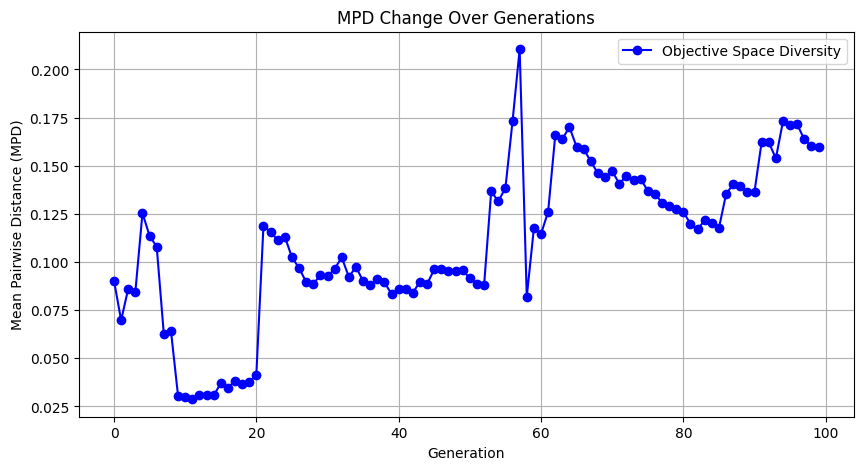

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(GeneticAlgorithmConfig.mpd_objective)), GeneticAlgorithmConfig.mpd_objective, label="Objective Space Diversity", marker='o', linestyle='-', color='b')
plt.xlabel("Generation")
plt.ylabel("Mean Pairwise Distance (MPD)")
plt.title("MPD Change Over Generations")
plt.legend()
plt.grid()
plt.show()

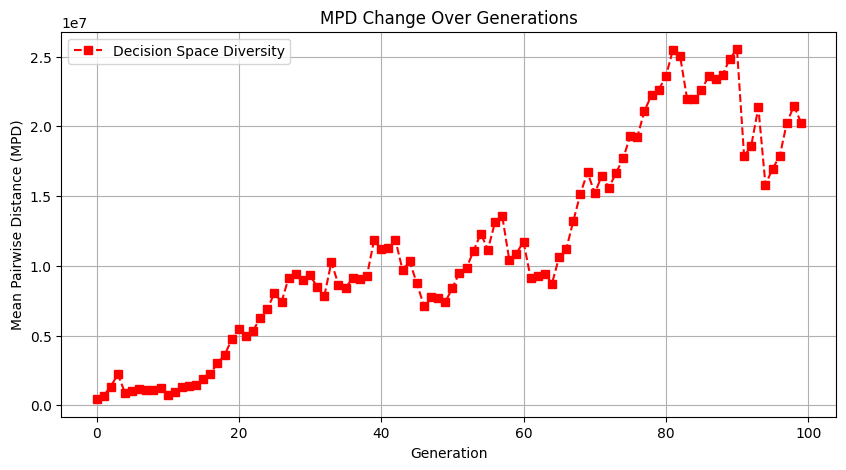

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(GeneticAlgorithmConfig.mpd_decision)), GeneticAlgorithmConfig.mpd_decision, label="Decision Space Diversity", marker='s', linestyle='--', color='r')
plt.xlabel("Generation")
plt.ylabel("Mean Pairwise Distance (MPD)")
plt.title("MPD Change Over Generations")
plt.legend()
plt.grid()
plt.show()

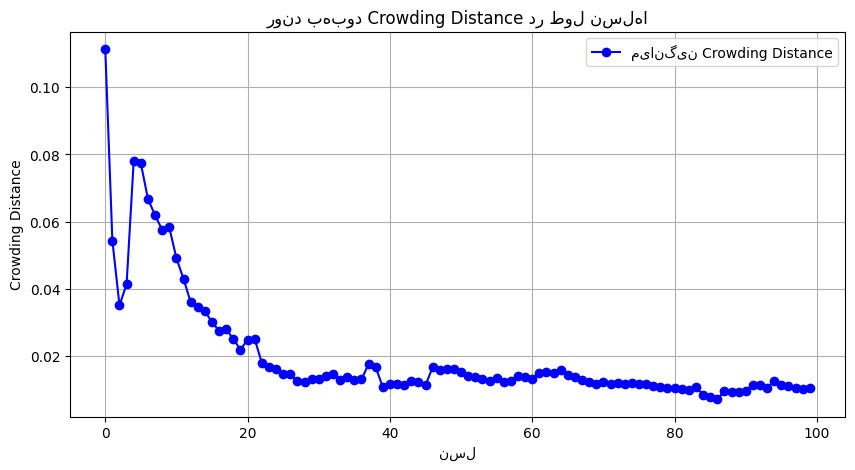

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(GeneticAlgorithmConfig.cd, label="میانگین Crowding Distance", marker="o", color="blue")
plt.xlabel("نسل")
plt.ylabel("Crowding Distance")
plt.title("روند بهبود Crowding Distance در طول نسل‌ها")
plt.legend()
plt.grid()
plt.show()

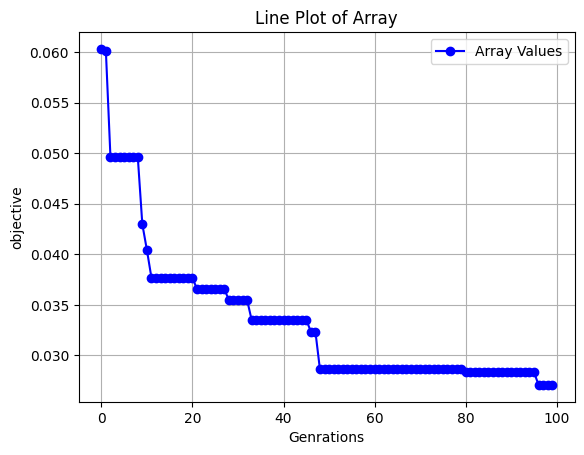

In [22]:
plt.plot(range(len(GeneticAlgorithmConfig.best)), GeneticAlgorithmConfig.best, marker='o', linestyle='-', color='b', label="Array Values")
plt.xlabel("Genrations")
plt.ylabel("objective")
plt.title("Line Plot of Array")
plt.legend()
plt.grid(True)
plt.show()

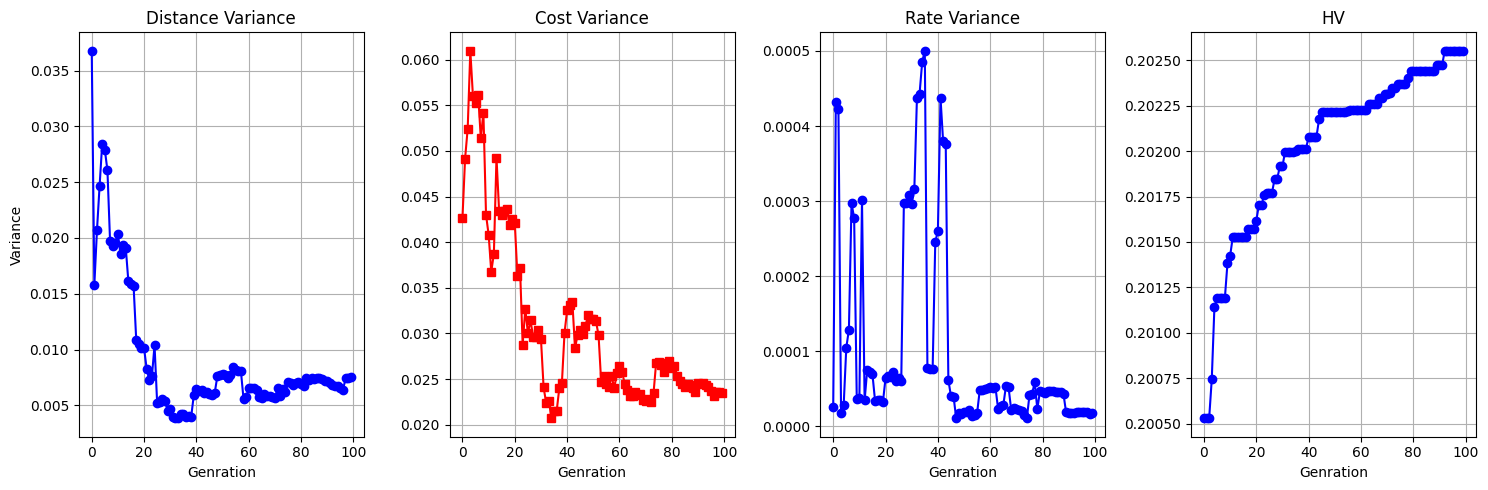

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# رسم نمودار واریانس

fig, axes = plt.subplots(1, 4, figsize=(15, 5))


axes[0].plot(GeneticAlgorithmConfig.distance_variance, 'b-o', label='Distance Variance')
axes[0].set_title("Distance Variance")
axes[0].set_xlabel("Genration")
axes[0].set_ylabel("Variance")
axes[0].grid(True)

# نمودار واریانس هزینه
axes[1].plot(GeneticAlgorithmConfig.cost_variance, 'r-s', label='Cost Variance')
axes[1].set_title("Cost Variance")
axes[1].set_xlabel("Genration")
axes[1].grid(True)

# نمودار واریانس نرخ
axes[2].plot(range(len(GeneticAlgorithmConfig.rate_variance)), GeneticAlgorithmConfig.rate_variance, 'b-o', label='Rate Variance')
axes[2].set_title("Rate Variance")
axes[2].set_xlabel("Genration")
axes[2].grid(True)


axes[3].plot(GeneticAlgorithmConfig.HV, 'b-o', label='HV')
axes[3].set_title("HV")
axes[3].set_xlabel("Genration")
axes[3].grid(True)

# تنظیم فاصله بین نمودارها
plt.tight_layout()
plt.show()

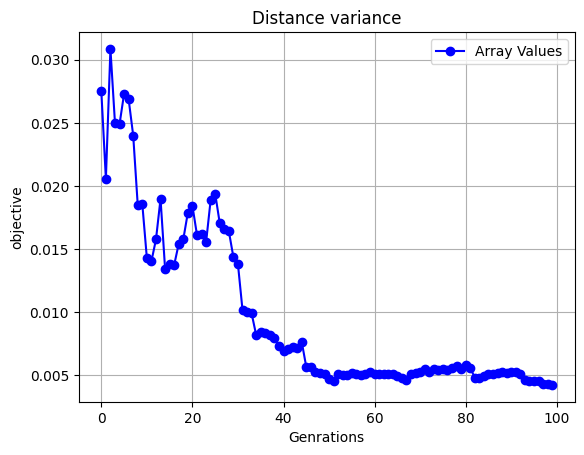

In [ ]:
plt.plot(GeneticAlgorithmConfig.distance_variance, marker='o', linestyle='-', color='b', label="Array Values")
plt.xlabel("Genrations")
plt.ylabel("objective")
plt.title("Distance variance")
plt.legend()
plt.grid(True)
plt.show()

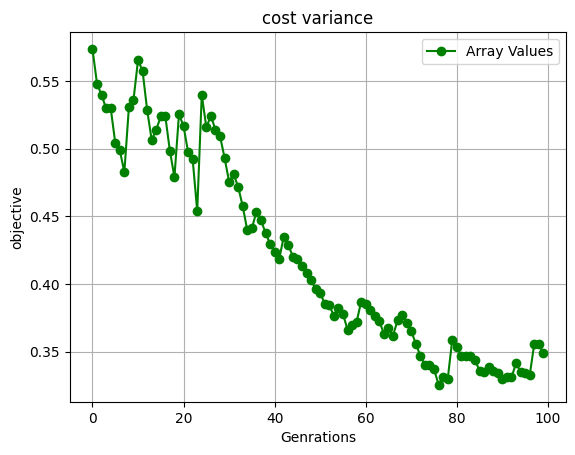

In [ ]:
plt.plot(GeneticAlgorithmConfig.cost_variance, marker='o', linestyle='-', color='g', label="Array Values")
plt.xlabel("Genrations")
plt.ylabel("objective")
plt.title("cost variance")
plt.legend()
plt.grid(True)
plt.show()

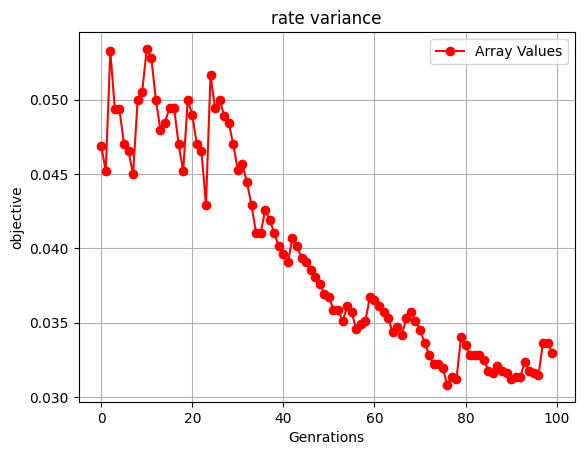

In [ ]:
plt.plot(GeneticAlgorithmConfig.rate_variance, marker='o', linestyle='-', color='r', label="Array Values")
plt.xlabel("Genrations")
plt.ylabel("objective")
plt.title("rate variance")
plt.legend()
plt.grid(True)
plt.show()

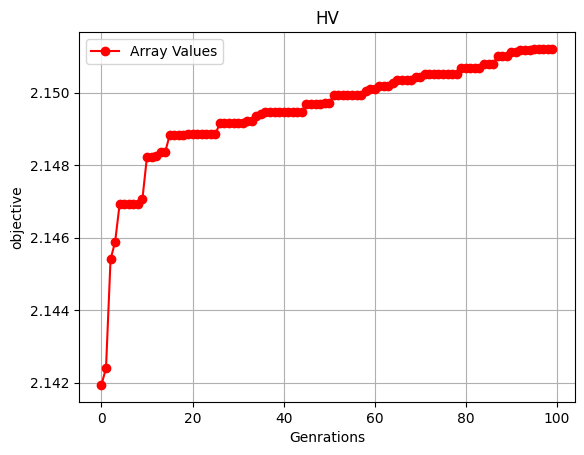

In [ ]:
plt.plot(GeneticAlgorithmConfig.HV, marker='o', linestyle='-', color='r', label="Array Values")
plt.xlabel("Genrations")
plt.ylabel("objective")
plt.title("HV")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import folium

# ایجاد یک نقشه در مرکز اولین مکان
map_center = [locations["Longitude"].mean(), locations["Latitude"].mean()]
mymap = folium.Map(location=map_center, zoom_start=13)

index = 0
pareto_solutions = res.X
startRoute = GeneticAlgorithmConfig.totalLocationSize
endRoute  = (pareto_solutions[0][index][0] * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * 2)
for j in range(startRoute,
                endRoute,
                GeneticAlgorithmConfig.timePlaceMappingSize):
  node = locations[locations["Id"] == pareto_solutions[0][index][j]]
  color = 'blue'

  folium.Marker(
      location=[node["Longitude"].values[0], node["Latitude"].values[0]],
      popup=node["tag"].values[0],
      tooltip=f"{node['name'].values[0]}",
      icon=folium.Icon(color=color)
  ).add_to(mymap)


mymap




IndexError: invalid index to scalar variable.